# KNN Analysis

### Importing Libraries and Setting Up the Environment
This block sets up the environment by importing necessary libraries, configuring paths, and preparing the workspace.

In [15]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


import os
os.chdir("/home/csartori/GNN_E")


from utils_models import *

import pandas as pd
from math import ceil
import gc
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading and Preparing the Dataset
This block loads the labeled movie dataset and defines constants such as the number of classes and batch size.

In [16]:
# Load all movies with labels csv
df_all_movies = pd.read_csv("/home/dalai/GNN_E/data/processed/all_movies_labelled_13_single.csv")

In [17]:
# Load rest dataset (not used directly in this script)
df_rest = pd.read_csv("/home/dalai/GNN_E/data/raw/rest/Rest_compiled414_processed.csv")

In [18]:
os.chdir("/home/csartori/GNN_E")


# Split in train and test
df_train, df_val, df_test = split_train_val_test_horizontally(
    df_all_movies,
    percentage_train=0.8,
    percentage_val=0.0,  # 0 to not have any validation set
    path_pickle_delay="data/raw/labels/run_onsets.pkl",
    path_movie_title_mapping="data/raw/labels/category_mapping_movies.csv",
    tr_len=1.3,
)

# Print label distributions for sanity checking
print(df_train[df_train.label != -1]["label"].count() / 414)
print(df_test[df_test.label != -1]["label"].count() / 414)


Movie: AfterTheRain
  Start Time (TR)+4: 80
  Total Length (TR): 382
  Train End (TR): 385
  Validation End (TR): 385
  Movie End (TR): 462

Movie: BetweenViewings
  Start Time (TR)+4: 79
  Total Length (TR): 622
  Train End (TR): 576
  Validation End (TR): 576
  Movie End (TR): 701

Movie: BigBuckBunny
  Start Time (TR)+4: 79
  Total Length (TR): 377
  Train End (TR): 380
  Validation End (TR): 380
  Movie End (TR): 456

Movie: Chatter
  Start Time (TR)+4: 79
  Total Length (TR): 312
  Train End (TR): 328
  Validation End (TR): 328
  Movie End (TR): 391

Movie: FirstBite
  Start Time (TR)+4: 79
  Total Length (TR): 461
  Train End (TR): 447
  Validation End (TR): 447
  Movie End (TR): 540

Movie: LessonLearned
  Start Time (TR)+4: 79
  Total Length (TR): 513
  Train End (TR): 489
  Validation End (TR): 489
  Movie End (TR): 592

Movie: Payload
  Start Time (TR)+4: 79
  Total Length (TR): 775
  Train End (TR): 699
  Validation End (TR): 699
  Movie End (TR): 854

Movie: Sintel
  Start

### Feature Extraction
This section includes functions to extract features for each movie, subject, and timepoint. Rich features include detailed statistical and temporal trends, while simplified features capture only basic statistics.

In [19]:
from joblib import Parallel, delayed


def process_timepoint(movie, subject, timepoint, df_single_movie_sub, sizewind, feature_rich):
    """
    Processes a single timepoint to extract features and labels.
    """
    print(f"Processing {movie} - {subject} - {timepoint}")
    time_around = range(timepoint - sizewind, timepoint + sizewind + 1)
    x = df_single_movie_sub.loc[df_single_movie_sub.timestamp_tr.isin(time_around), ["vindex", "score", "timestamp_tr"]]

    features = []

    if feature_rich:
        # Rich Features
        x_pivot = x.pivot(index="vindex", columns="timestamp_tr", values="score").fillna(0)
        flattened_features = x_pivot.values.flatten()

        # Temporal trends
        trend = x["score"].diff().mean()  # Average change in scores
        ratio = x["score"].iloc[-1] / (x["score"].iloc[0] + 1e-5)  # Last-to-first ratio

        # Statistical summaries
        stats = [x["score"].mean(), x["score"].std(), x["score"].min(), x["score"].max(), x["score"].var()]

        # Aggregate features
        vindex_groups = df_single_movie_sub.groupby("vindex")["score"]
        vindex_means = vindex_groups.mean()
        vindex_stds = vindex_groups.std()

        # Combine all rich features
        features.extend(flattened_features)
        features.extend(stats)
        features.extend([trend, ratio])
        features.extend(vindex_means.tolist())
        features.extend(vindex_stds.tolist())
    else:
        # Simplified Features: Just basic statistics
        stats = [x["score"].mean(), x["score"].std(), x["score"].min(), x["score"].max(), x["score"].var()]
        features.extend(stats)

    # Label
    label = df_single_movie_sub[df_single_movie_sub.timestamp_tr == timepoint]["label"].unique()[0]

    return features, label


def process_subject(movie, subject, df_single_movie, sizewind, feature_rich):
    """
    Processes a single subject to extract features and labels for all timepoints.
    """
    df_single_movie_sub = df_single_movie[df_single_movie.id == subject]
    timepoints = df_single_movie_sub[df_single_movie_sub.label != -1]["timestamp_tr"].unique()

    results = [
        process_timepoint(movie, subject, timepoint, df_single_movie_sub, sizewind, feature_rich)
        for timepoint in timepoints
    ]
    return results


def create_features(df, sizewind=4, feature_rich=True, n_jobs=-1):
    """
    Parallelized feature creation for KNN and Random Forest with feature-rich control.
    """
    movies = df["movie"].unique()

    # Parallelized processing across movies
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_movie)(movie, df[df.movie == movie], sizewind, feature_rich) for movie in movies
    )

    # Flatten results
    X = []
    y = []
    for movie_results in results:
        for subject_results in movie_results:
            for features, label in subject_results:
                X.append(features)
                y.append(label)

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y


def process_movie(movie, df_single_movie, sizewind, feature_rich):
    """
    Processes a single movie by iterating over its subjects.
    """
    subjects = df_single_movie["id"].unique()
    return [
        process_subject(movie, subject, df_single_movie, sizewind, feature_rich) for subject in subjects
    ]

### Generating Features for Training and Testing
Using the feature extraction functions, features are generated for both the training and testing datasets.

In [20]:
half_wind_size = 4
feature_rich = True

print("Creating features for train")
X_train, y_train = create_features(df_train, sizewind=half_wind_size, feature_rich=feature_rich, n_jobs=-1)

print("Creating features for test")
X_test, y_test = create_features(df_test, sizewind=half_wind_size, feature_rich=feature_rich, n_jobs=-1)

Creating features for train
Processing 0 - 1 - 80
Processing 0 - 1 - 81
Processing 0 - 1 - 82
Processing 0 - 1 - 83
Processing 0 - 1 - 84
Processing 0 - 1 - 85
Processing 0 - 1 - 86
Processing 0 - 1 - 87
Processing 0 - 1 - 88
Processing 0 - 1 - 89
Processing 0 - 1 - 90
Processing 0 - 1 - 91
Processing 0 - 1 - 92
Processing 0 - 1 - 93
Processing 0 - 1 - 94
Processing 0 - 1 - 95
Processing 0 - 1 - 96
Processing 0 - 1 - 97
Processing 0 - 1 - 98
Processing 0 - 1 - 99
Processing 0 - 1 - 100
Processing 0 - 1 - 101
Processing 0 - 1 - 102
Processing 0 - 1 - 103
Processing 0 - 1 - 104
Processing 0 - 1 - 105
Processing 0 - 1 - 106
Processing 0 - 1 - 107
Processing 0 - 1 - 108
Processing 0 - 1 - 109
Processing 0 - 1 - 110
Processing 0 - 1 - 111
Processing 0 - 1 - 112
Processing 0 - 1 - 113
Processing 0 - 1 - 114
Processing 0 - 1 - 115
Processing 0 - 1 - 116
Processing 0 - 1 - 117
Processing 0 - 1 - 118
Processing 0 - 1 - 119
Processing 0 - 1 - 120
Processing 0 - 1 - 121
Processing 0 - 1 - 122
Pro

### Normalizing Features
This step standardizes the features using `StandardScaler` for better performance with KNN.

In [21]:
from sklearn.preprocessing import StandardScaler
# Normalize features for KNN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### KNN

In [22]:
# Create and train KNN model
k = 500  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

### Evaluating Model Performance
Predicts on the test set and calculates accuracy.

In [23]:
# Predict on test data
y_test_pred = knn_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 9.39%


### Confusion Matrix and Classification Report
Visualize performance using a confusion matrix and a detailed classification report.

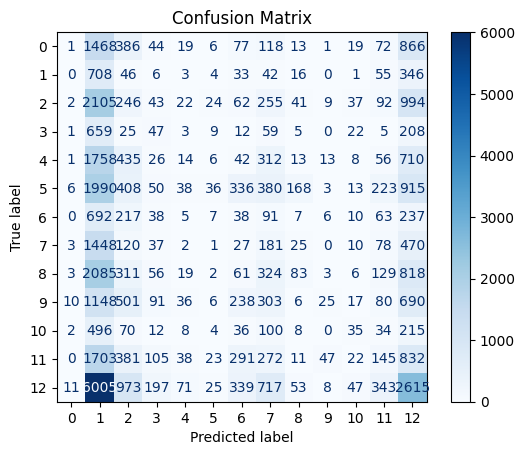

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.03      0.00      0.00      3090
     Class 1       0.03      0.56      0.06      1260
     Class 2       0.06      0.06      0.06      3932
     Class 3       0.06      0.04      0.05      1055
     Class 4       0.05      0.00      0.01      3394
     Class 5       0.24      0.01      0.02      4566
     Class 6       0.02      0.03      0.03      1411
     Class 7       0.06      0.08      0.07      2402
     Class 8       0.18      0.02      0.04      3900
     Class 9       0.22      0.01      0.02      3151
    Class 10       0.14      0.03      0.06      1020
    Class 11       0.11      0.04      0.06      3870
    Class 12       0.26      0.23      0.25     11404

    accuracy                           0.09     44455
   macro avg       0.11      0.09      0.05     44455
weighted avg       0.15      0.09      0.09     44455



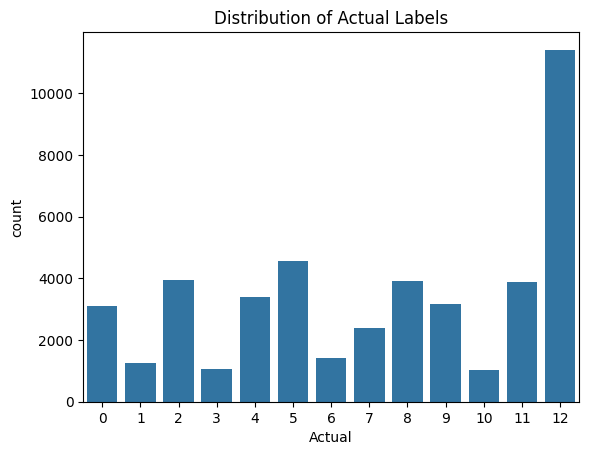

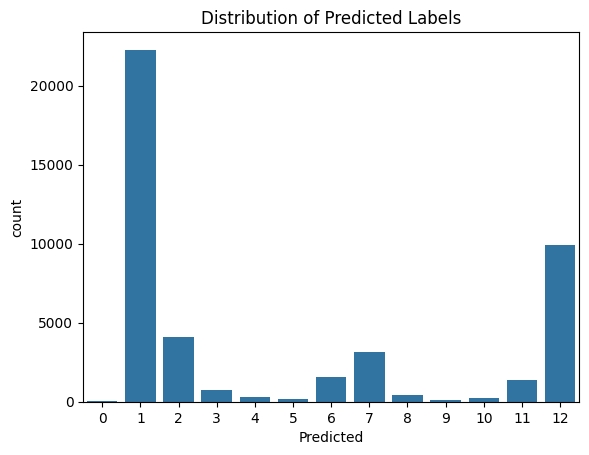

Class Accuracy:
 {0: 0.00032362459546925567, 1: 0.5619047619047619, 2: 0.06256358087487283, 3: 0.04454976303317536, 4: 0.0041249263406010605, 5: 0.00788436268068331, 6: 0.026931254429482635, 7: 0.07535387177352207, 8: 0.02128205128205128, 9: 0.007933989209774674, 10: 0.03431372549019608, 11: 0.037467700258397935, 12: 0.22930550683970535}
Errors:
    Actual  Predicted
0       5          1
1       5          1
2       5          1
3       5          1
4       5          1


In [24]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_test, y_test_pred, target_names=[f"Class {i}" for i in np.unique(y_test)])
print("Classification Report:\n", report)

# Distribution of Predictions
pred_dist = pd.DataFrame({"Actual": y_test, "Predicted": y_test_pred})
sns.countplot(data=pred_dist, x="Actual", order=sorted(pred_dist["Actual"].unique()))
plt.title("Distribution of Actual Labels")
plt.show()

sns.countplot(data=pred_dist, x="Predicted", order=sorted(pred_dist["Predicted"].unique()))
plt.title("Distribution of Predicted Labels")
plt.show()

# Accuracy per Class
class_accuracy = {}
for cls in np.unique(y_test):
    mask = y_test == cls
    class_accuracy[cls] = accuracy_score(y_test[mask], y_test_pred[mask])

print("Class Accuracy:\n", class_accuracy)

# Error Analysis
errors = pd.DataFrame({"Actual": y_test, "Predicted": y_test_pred})
errors = errors[errors["Actual"] != errors["Predicted"]]
print("Errors:\n", errors.head())



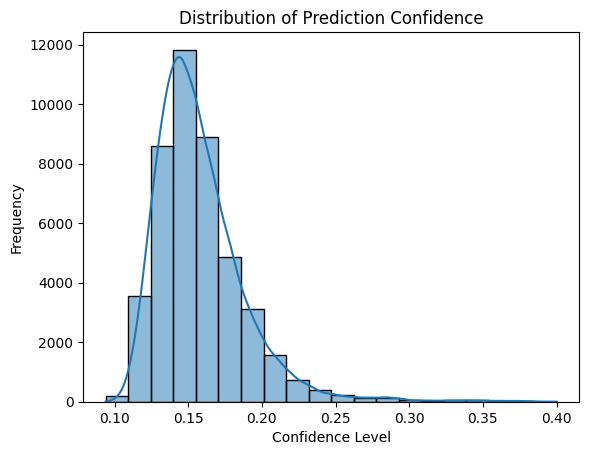

In [25]:
y_proba = knn_model.predict_proba(X_test)
sns.histplot(y_proba.max(axis=1), bins=20, kde=True)
plt.title("Distribution of Prediction Confidence")
plt.xlabel("Confidence Level")
plt.ylabel("Frequency")
plt.show()